In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
dat = pd.read_csv('Appointment.csv')
dat.head(5)

,Gender,Age,Scheduled_Day,Appointment_Day,Day_Difference,Day_of_Week,Scholarship,SMS_Received,With_Condition,No_Show
0,F,62,2016-04-29,2016-04-29,0,Friday,No,No,Yes,No
1,M,56,2016-04-29,2016-04-29,0,Friday,No,No,No,No
2,F,62,2016-04-29,2016-04-29,0,Friday,No,No,No,No
3,F,8,2016-04-29,2016-04-29,0,Friday,No,No,No,No
4,F,56,2016-04-29,2016-04-29,0,Friday,No,No,Yes,No


# test the key metric: SMS vs No SMS

In [3]:
# create two new tables: one table with sms received and one table without
# find out about the size of each table
sms = dat.loc[lambda x: dat['SMS_Received'] == 'Yes'].reset_index(drop = True)
no_sms = dat.loc[lambda x: dat['SMS_Received'] == 'No'].reset_index(drop = True)

## adjust data for later purposes (remove data with unrealistic traits)
# people with age 1 and have scholarship (doesn't make sense)   
# limit to people age from 16+ 
sms = sms.loc[lambda x: sms['Age'] >= 16]
no_sms = no_sms.loc[lambda x: no_sms['Age'] >= 16]

# making sure day difference between scheduled day and appointment day is positive
sms = sms.loc[lambda x: sms['Day_Difference'] >= 0]
no_sms = no_sms.loc[lambda x: no_sms['Day_Difference'] >= 0]

print('SMS Received sample size:', len(sms))
print('No SMS Received sample size:', len(no_sms))
print('\n')

# SMS Received: Calculate the proportion of people who show/no show 
print('Number show and received SMS:', len(sms[sms['No_Show'] == 'No']))
print('Number no show and received SMS:', len(sms[sms['No_Show'] == 'Yes']))
print('Proportion of no show (SMS):', len(sms[sms['No_Show'] == 'Yes'])/len(sms))
print('\n')

# No SMS Received: Calculate the proportion of people who show/no show
print('Number show and received no SMS:', len(no_sms[no_sms['No_Show'] == 'No']))
print('Number no show and received no SMS:', len(no_sms[no_sms['No_Show'] == 'Yes']))
print('Proportion of no show (No SMS):', len(no_sms[no_sms['No_Show'] == 'Yes'])/len(no_sms))

SMS Received sample size: 28248
No SMS Received sample size: 57744


Number show and received SMS: 20619
Number no show and received SMS: 7629
Proportion of no show (SMS): 0.27007221750212407


Number show and received no SMS: 48325
Number no show and received no SMS: 9419
Proportion of no show (No SMS): 0.16311651426988086


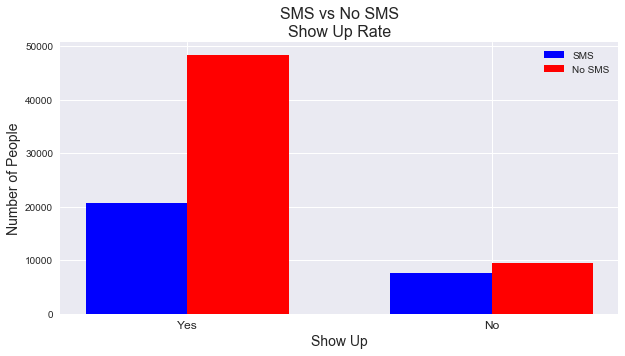

In [4]:
# Barplots for SMS vs No SMS

# Assign variables for graph: (Show and No Show)
obj = sms['No_Show'].unique()
x_pos = np.arange(len(obj))
wid = np.min(np.diff(x_pos))/3
plt.figure(figsize=(10,5))

sms_y_pos = [len(sms[sms['No_Show'] == 'No']), len(sms[sms['No_Show'] == 'Yes'])]
no_sms_y_pos = [len(no_sms[no_sms['No_Show'] == 'No']), len(no_sms[no_sms['No_Show'] == 'Yes'])]

ax = plt.subplot()
ax.bar(x_pos-wid/2, sms_y_pos, width = wid, color = 'blue', label = 'SMS') # SMS
ax.bar(x_pos+wid/2, no_sms_y_pos,  width = wid, color = 'red', label = 'No SMS') # No SMS


ax.set_xticks(x_pos)
ax.set_xticklabels(obj, fontsize = 12)
ax.set_ylabel('Number of People', fontsize = 14)
ax.set_xlabel('Show Up', fontsize = 14)
ax.set_title('SMS vs No SMS' + '\n' + 'Show Up Rate', fontsize = 16)
ax.legend(fontsize = 10)

plt.savefig('SMS_vs_No_SMS.png')
plt.show()

From the Bar Graph, it is clear that patiences who did not received SMS message were more likely to show up to appointment. 

In [5]:
# create an contigency table for SMS vs No SMS
index = ['SMS', 'No SMS']
conti_sms = pd.DataFrame({'Show': [len(sms[sms['No_Show'] == 'No']), len(no_sms[no_sms['No_Show'] == 'No'])],
                          'No Show': [len(sms[sms['No_Show'] == 'Yes']), len(no_sms[no_sms['No_Show'] == 'Yes'])]},
                        index = index)

# perform chi square contigency test for independence
# Null: SMS messages are independent from show up rate
# Alt: SMS messages (based on SMS) are dependent on show up rate
Chi_Value, P_Value, Dof, Expected = stats.chi2_contingency(conti_sms)
print(conti_sms, '\n')               #Observed Table
print('Chi Value:',Chi_Value)        #Chi-Square test stastitic
print('P-Value:', P_Value)           #P-Value
print('Deg of Freedom', Dof, '\n')   #Degree of Freedom
print(pd.DataFrame(Expected))        #Expected Table

        No Show   Show
SMS        7629  20619
No SMS     9419  48325 

Chi Value: 1364.50933234
P-Value: 1.08317178386e-298
Deg of Freedom 1 

              0             1
0   5600.194251  22647.805749
1  11447.805749  46296.194251


With the critical value of chi-square being unusually large, the data are clearly dependent on each other.

In [6]:
# Want to replace Yes/No with 1 or 0 for T-test
# No_Show: yes - did not show up => assign 1
#          no - showed up => assign 0           
sms_temp = sms['No_Show'].replace(['Yes'], 1) 
sms_temp = sms_temp.replace(['No'], 0) 

no_sms_temp = no_sms['No_Show'].replace(['Yes'], 1) 
no_sms_temp = no_sms_temp.replace(['No'], 0) 

# perform 2 sample t-test with independent variables
print('T-test:', stats.ttest_ind(sms_temp, no_sms_temp))

T-test: Ttest_indResult(statistic=37.244767666000001, pvalue=3.2893128454160202e-301)


From the result, it has a high t-value and extremely low p-value. There is a huge difference between the two data

# test on scholarship

In [7]:
# Perform test on patiences who received sms and has scholarship
scholar_sms = sms[sms['Scholarship'] == 'Yes']
scholar_no_sms = no_sms[no_sms['Scholarship'] == 'Yes']

print('Received SMS')
print('total number:', len(scholar_sms))
print('total number of no show:', len(scholar_sms[scholar_sms['No_Show'] == 'Yes']))
print('proportion of no show:', len(scholar_sms[scholar_sms['No_Show'] == 'Yes'])/len(scholar_sms))
print('\n')

print('Did not received SMS')
print('total number:', len(scholar_no_sms))
print('total number of no show:', len(scholar_no_sms[scholar_no_sms['No_Show'] == 'Yes']))
print('proportion of no show:', len(scholar_no_sms[scholar_no_sms['No_Show'] == 'Yes'])/len(scholar_no_sms))

Received SMS
total number: 2735
total number of no show: 935
proportion of no show: 0.34186471663619744


Did not received SMS
total number: 5512
total number of no show: 1028
proportion of no show: 0.18650217706821481


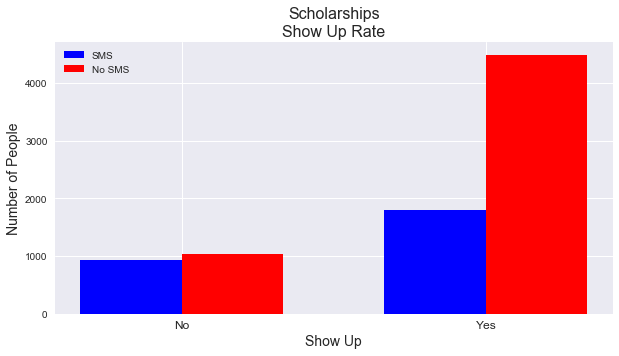

In [8]:
# Barplots for Scholarship (Based on SMS and No SMS)

# Assign variables for graph: (Show and No Show)
obj = scholar_sms['No_Show'].unique()
x_pos = np.arange(len(obj))
wid = np.min(np.diff(x_pos))/3
plt.figure(figsize=(10,5))

sms_y_pos = [len(scholar_sms[scholar_sms['No_Show'] == 'Yes']), len(scholar_sms[scholar_sms['No_Show'] == 'No'])]
no_sms_y_pos = [len(scholar_no_sms[scholar_no_sms['No_Show'] == 'Yes']), len(scholar_no_sms[scholar_no_sms['No_Show'] == 'No'])]

ax = plt.subplot()
ax.bar(x_pos-wid/2, sms_y_pos, width = wid, color = 'blue', label = 'SMS') # SMS
ax.bar(x_pos+wid/2, no_sms_y_pos,  width = wid, color = 'red', label = 'No SMS') # No SMS


ax.set_xticks(x_pos)
ax.set_xticklabels(obj, fontsize = 12)
ax.set_ylabel('Number of People', fontsize = 14)
ax.set_xlabel('Show Up', fontsize = 14)
ax.set_title('Scholarships' + '\n' + 'Show Up Rate', fontsize = 16)
ax.legend(fontsize = 10)

plt.savefig('Scholarship.png')
plt.show()

In [9]:
# create an contigency table for SMS vs No SMS
# Null: Scholarships (based on SMS) are independent from show up rate
# Alt: Scholarships (based on SMS) are dependent on show up rate
index = ['SMS', 'No SMS']
conti_scholar = pd.DataFrame({'No Show': [len(scholar_sms[scholar_sms['No_Show'] == 'Yes']),
                                      len(scholar_no_sms[scholar_no_sms['No_Show'] == 'Yes'])],
                              'Show': [len(scholar_sms[scholar_sms['No_Show'] == 'No']),
                                   len(scholar_no_sms[scholar_no_sms['No_Show'] == 'No'])]},
                        index = index)

# perform chi square contigency test for independence
Chi_Value, P_Value, Dof, Expected = stats.chi2_contingency(conti_scholar)
print(conti_scholar, '\n')           #Observed Table
print('Chi test stat:',Chi_Value)    #Chi-Square test stastitic
print('P-Value:', P_Value)           #P-Value
print('Deg of Freedom', Dof, '\n')   #Degree of Freedom
print(pd.DataFrame(Expected))        #Expected Table

        No Show  Show
SMS         935  1800
No SMS     1028  4484 

Chi test stat: 242.41981896
P-Value: 1.16704546016e-54
Deg of Freedom 1 

            0           1
0   651.00097  2083.99903
1  1311.99903  4200.00097


In [10]:
# For T-test, want to replace Yes/No with 1 or 0
# No_Show: yes - did not show up => assign 1
#          no - showed up => assign 0           
sms_temp = scholar_sms['No_Show'].replace(['Yes'], 1) 
sms_temp = sms_temp.replace(['No'], 0) 

no_sms_temp = scholar_no_sms['No_Show'].replace(['Yes'], 1) 
no_sms_temp = no_sms_temp.replace(['No'], 0) 

# perform 2 sample t-test with independent variables
print('T-test:', stats.ttest_ind(sms_temp, no_sms_temp))

T-test: Ttest_indResult(statistic=15.830644992148573, pvalue=1.2553049064051024e-55)


The results from scholarship show up rate are similar to the results from SMS vs No SMS. 

# test on with_condition

In [11]:
# Perform test on patiences who received sms and has scholarship
cond_sms = sms[sms['With_Condition'] == 'Yes']
cond_no_sms = no_sms[no_sms['With_Condition'] == 'Yes']


print('Received SMS')
print('total number:', len(cond_sms))
print('total number of no show:', len(cond_sms[cond_sms['No_Show'] == 'Yes']))
print('proportion of no show:', len(cond_sms[cond_sms['No_Show'] == 'Yes'])/len(cond_sms))
print('\n')

print('Did not received SMS')
print('total number:', len(cond_no_sms))
print('total number of no show:', len(cond_no_sms[cond_no_sms['No_Show'] == 'Yes']))
print('proportion of no show:', len(cond_no_sms[cond_no_sms['No_Show'] == 'Yes'])/len(cond_no_sms))

Received SMS
total number: 7956
total number of no show: 1876
proportion of no show: 0.23579688285570638


Did not received SMS
total number: 18177
total number of no show: 2736
proportion of no show: 0.15051988777025913


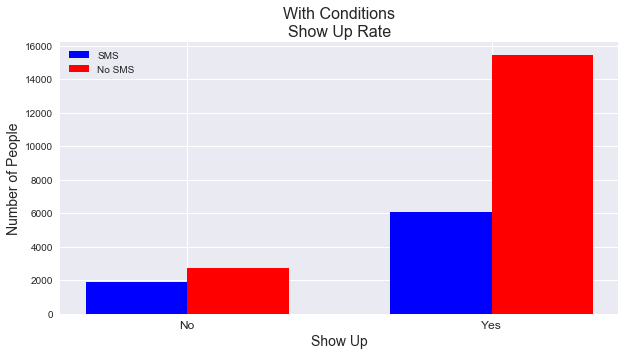

In [12]:
# Barplots for Conditions (Based on SMS and No SMS)

# Assign variables for graph: (Show and No Show)
obj = cond_sms['No_Show'].unique()
x_pos = np.arange(len(obj))
wid = np.min(np.diff(x_pos))/3
plt.figure(figsize=(10,5))

sms_y_pos = [len(cond_sms[cond_sms['No_Show'] == 'Yes']), len(cond_sms[cond_sms['No_Show'] == 'No'])]
no_sms_y_pos = [len(cond_no_sms[cond_no_sms['No_Show'] == 'Yes']), len(cond_no_sms[cond_no_sms['No_Show'] == 'No'])]

ax = plt.subplot()
ax.bar(x_pos-wid/2, sms_y_pos, width = wid, color = 'blue', label = 'SMS') # SMS
ax.bar(x_pos+wid/2, no_sms_y_pos,  width = wid, color = 'red', label = 'No SMS') # No SMS


ax.set_xticks(x_pos)
ax.set_xticklabels(obj, fontsize = 12)
ax.set_ylabel('Number of People', fontsize = 14)
ax.set_xlabel('Show Up', fontsize = 14)
ax.set_title('With Conditions' + '\n' + 'Show Up Rate', fontsize = 16)
ax.legend(fontsize = 10)

plt.savefig('With_condition.png')
plt.show()

In [13]:
# create an contigency table for patiences with conditions (based on sms/no sms dataframe)
# Null: With Conditions (based on SMS) are independent from show up rate
# Alt: With Conditions (based on SMS) are dependent on show up rate
index = ['SMS', 'No SMS']
conti_wc = pd.DataFrame({'No Show': [len(cond_sms[cond_sms['No_Show'] == 'Yes']), 
                                     len(cond_no_sms[cond_no_sms['No_Show'] == 'Yes'])],
                         'Show': [len(cond_sms[cond_sms['No_Show'] == 'No']),
                                  len(cond_no_sms[cond_no_sms['No_Show'] == 'No'])]},
                        index = index)

# perform chi square contigency test for independence
Chi_Value, P_Value, Dof, Expected = stats.chi2_contingency(conti_wc)
print(conti_wc, '\n')                #Observed Table
print('Chi test stat:',Chi_Value)    #Chi-Square test stastitic
print('P-Value:', P_Value)           #P-Value
print('Deg of Freedom', Dof, '\n')   #Degree of Freedom
print(pd.DataFrame(Expected))        #Expected Table

        No Show   Show
SMS        1876   6080
No SMS     2736  15441 

Chi test stat: 276.31057299
P-Value: 4.78194911664e-62
Deg of Freedom 1 

             0             1
0  1404.089542   6551.910458
1  3207.910458  14969.089542


In [14]:
# For T-test, want to replace Yes/No with 1 or 0
# No_Show: yes - did not show up => assign 1
#          no - showed up => assign 0           
sms_temp = cond_sms['No_Show'].replace(['Yes'], 1) 
sms_temp = sms_temp.replace(['No'], 0) 

no_sms_temp = cond_no_sms['No_Show'].replace(['Yes'], 1) 
no_sms_temp = no_sms_temp.replace(['No'], 0) 

# perform 2 sample t-test with independent variables
print('T-test:', stats.ttest_ind(sms_temp, no_sms_temp))

T-test: Ttest_indResult(statistic=16.728446865643676, pvalue=1.7204567670659871e-62)


The results from conditions show up rate are also similar to the results from SMS vs No SMS. 

# create an contigency table for the following metrics:
    # sms/no sms
    # condtions
    # scholarships
    

In [15]:
# create contigency for the 3 variables (focus on 'no show')
# Null: The 3 data above (based on SMS) are independent from show up rate
# Alt: The 3 data above (based on SMS) are dependent on show up rate
index = ['SMS', 'No SMS']
conti = pd.DataFrame({'SMS/No SMS': [len(sms[sms['No_Show'] == 'Yes']), len(no_sms[no_sms['No_Show'] == 'Yes'])],
                      'Scholarship': [len(scholar_sms[scholar_sms['No_Show'] == 'Yes']),
                                      len(scholar_no_sms[scholar_no_sms['No_Show'] == 'Yes'])],
                      'Conditions': [len(cond_sms[cond_sms['No_Show'] == 'Yes']), 
                                     len(cond_no_sms[cond_no_sms['No_Show'] == 'Yes'])]},
                     index = index)

# perform chi square contigency test for independence
Chi_Value, P_Value, Dof, Expected = stats.chi2_contingency(conti)
print(conti, '\n')                   #Observed Table
print('Chi test stat:',Chi_Value)    #Chi-Square test stastitic
print('P-Value:', P_Value)           #P-Value
print('Deg of Freedom', Dof, '\n')   #Degree of Freedom
print(pd.DataFrame(Expected))        #Expected Table

        Conditions  SMS/No SMS  Scholarship
SMS           1876        7629          935
No SMS        2736        9419         1028 

Chi test stat: 34.6784141286
P-Value: 2.94902226457e-08
Deg of Freedom 2 

             0            1           2
0  2038.237311  7534.230199   867.53249
1  2573.762689  9513.769801  1095.46751


From the result of chi-square value and p-value, it looks like it will be rejecting the null hypothesis. Hence the data are dependent.

# test on day of week

In [16]:
print(sms['Day_of_Week'].unique())

# there is no appointment on Sundays
# want to create an array to sort the day of week accordingly
sorter = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

['Friday' 'Tuesday' 'Monday' 'Thursday' 'Wednesday' 'Saturday']


In [17]:
# create 2 array to store data for sms and no sms
sms_show_day = []
no_sms_show_day = []

for day in sorter:
    sms_data = sms[sms['Day_of_Week'] == day]
    no_sms_data = no_sms[no_sms['Day_of_Week'] == day]
    print('{}:'.format(day))    
    print('Total SMS:', len(sms_data))
    print('Number of SMS No Show:', len(sms_data[sms_data['No_Show'] == 'Yes']))
    print('Proportion of No Show:', len(sms_data[sms_data['No_Show'] == 'Yes'])/len(sms_data))
    sms_show_day.append(len(sms_data[sms_data['No_Show'] == 'Yes'])) # store the data for SMS no show for each day
    
    print('Total No SMS:', len(no_sms_data))
    print('Number of No SMS No Show:', len(no_sms_data[no_sms_data['No_Show'] == 'Yes']))
    print('Proportion of No show:', len(no_sms_data[no_sms_data['No_Show'] == 'Yes'])/len(no_sms_data))
    no_sms_show_day.append(len(no_sms_data[no_sms_data['No_Show'] == 'Yes'])) # store the data for No SMS no show for each day
    
    # For T-test, want to replace Yes/No with 1 or 0
    # No_Show: yes - did not show up => assign 1
    #          no - showed up => assign 0           
    sms_temp = sms_data['No_Show'].replace(['Yes'], 1) 
    sms_temp = sms_temp.replace(['No'], 0) 
    no_sms_temp = no_sms_data['No_Show'].replace(['Yes'], 1) 
    no_sms_temp = no_sms_temp.replace(['No'], 0) 
    
    print('T-test:', stats.ttest_ind(sms_temp, no_sms_temp))
    print('\n')
    

Monday:
Total SMS: 5617
Number of SMS No Show: 1506
Proportion of No Show: 0.2681146519494392
Total No SMS: 11853
Number of No SMS No Show: 2065
Proportion of No show: 0.17421749767991226
T-test: Ttest_indResult(statistic=14.458962102203571, pvalue=4.1180831151625319e-47)


Tuesday:
Total SMS: 8480
Number of SMS No Show: 2300
Proportion of No Show: 0.27122641509433965
Total No SMS: 11614
Number of No SMS No Show: 1721
Proportion of No show: 0.14818322713965904
T-test: Ttest_indResult(statistic=21.782660981165677, pvalue=5.4049534497937832e-104)


Wednesday:
Total SMS: 7036
Number of SMS No Show: 1865
Proportion of No Show: 0.26506537805571345
Total No SMS: 13040
Number of No SMS No Show: 1919
Proportion of No show: 0.14716257668711658
T-test: Ttest_indResult(statistic=20.592997796312414, pvalue=2.9171548581768336e-93)


Thursday:
Total SMS: 3813
Number of SMS No Show: 1081
Proportion of No Show: 0.2835038027799633
Total No SMS: 9673
Number of No SMS No Show: 1490
Proportion of No show:

In [18]:
print(sms_show_day)
print(no_sms_show_day)

[1506, 2300, 1865, 1081, 874, 3]
[2065, 1721, 1919, 1490, 2218, 6]


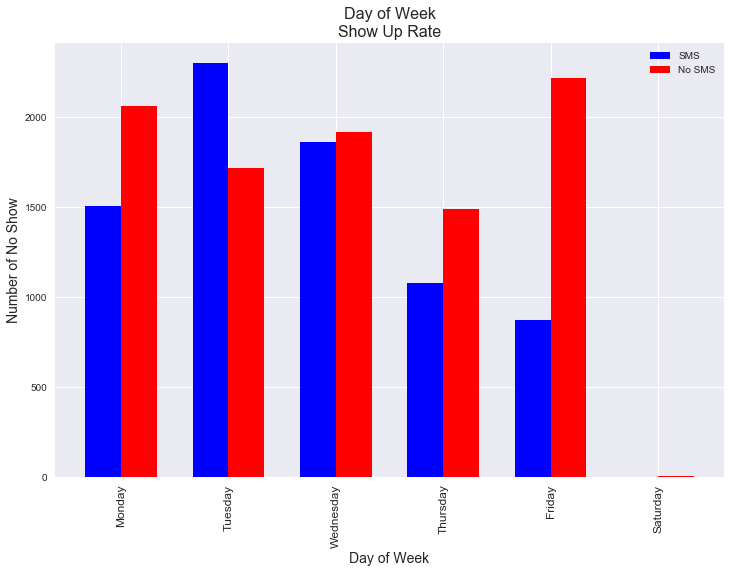

In [19]:
# Barplots for Day of Week (Based on SMS and No SMS)
# (focused on Number of No Show)

# Assign variables for graph: (No Show)
x_pos = np.arange(len(sorter))
wid = np.min(np.diff(x_pos))/3
plt.figure(figsize=(12,8))

ax = plt.subplot()
ax.bar(x_pos-wid/2, sms_show_day, width = wid, color = 'blue', label = 'SMS') # SMS
ax.bar(x_pos+wid/2, no_sms_show_day,  width = wid, color = 'red', label = 'No SMS') # No SMS


ax.set_xticks(x_pos)
ax.set_xticklabels(sorter, rotation = 90, fontsize = 12)
ax.set_ylabel('Number of No Show', fontsize = 14)
ax.set_xlabel('Day of Week', fontsize = 14)
ax.set_title('Day of Week' + '\n' + 'Show Up Rate', fontsize = 16)
ax.legend(fontsize = 10)

plt.savefig('Day_of_Week.png')
plt.show()

We can pratically ignore Saturday because it is insignificant. Although this graph is not as obvious, patiences who has not received SMS messages seem to be more likely to show up to doctor appointments with the exception of Tuesday.

In [20]:
# create an contigency table for day of week (based on sms/no sms)
# Null: The days of week (based on SMS) are independent from show up rate
# Alt: The days of week (based on SMS) are dependent on show up rate
conti_day = pd.DataFrame({'SMS': sms_show_day,
                          'No SMS': no_sms_show_day},
                         index = sorter)

# perform chi square contigency test for independence
Chi_Value, P_Value, Dof, Expected = stats.chi2_contingency(conti_day)
print(conti_day, '\n')               #Observed Table
print('Chi test stat:',Chi_Value)    #Chi-Square test stastitic
print('P-Value:', P_Value)           #P-Value
print('Deg of Freedom', Dof, '\n')   #Degree of Freedom
print(pd.DataFrame(Expected))        #Expected Table

           No SMS   SMS
Monday       2065  1506
Tuesday      1721  2300
Wednesday    1919  1865
Thursday     1490  1081
Friday       2218   874
Saturday        6     3 

Chi test stat: 641.030789178
P-Value: 2.74853199958e-136
Deg of Freedom 5 

             0            1
0  1972.973311  1598.026689
1  2221.597783  1799.402217
2  2090.655561  1693.344439
3  1420.474484  1150.525516
4  1708.326373  1383.673627
5     4.972489     4.027511


From the result above, it seems that 'day of week' and 'show up rate' are dependent

# test on age

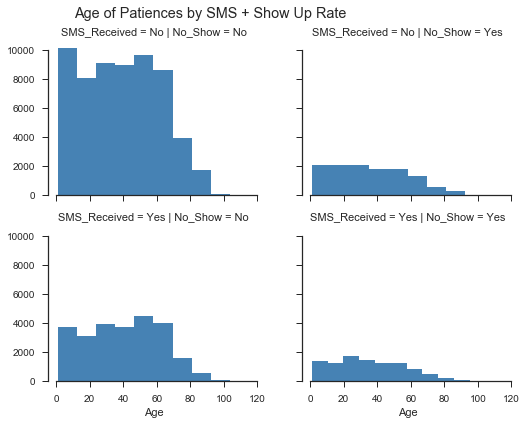

In [21]:
# Setting the overall aesthetic
sns.set(style = 'ticks')  
g = sns.FacetGrid(dat, row = 'SMS_Received', col = 'No_Show')

# Create a histogram based on Age and adjust the room of the plots
g.map(plt.hist, 'Age', color = 'steelblue', lw = 0)
plt.subplots_adjust(right = 1.2, top = 0.9)

g.set_axis_labels('Age')
sns.plt.suptitle('Age of Patiences by SMS + Show Up Rate')

sns.despine(trim=True)

plt.savefig('age.png')
plt.show()

In [22]:
# Create a Function to categorize the age groups into 4 categories
# binning, discretization

def age_group(var):
    group = []
    ind = var
    counts = []
    for x in var.index:
        if x <= 24:
            counts.append(ind[x])
            x = 'Kids'
            group.append(x)
        elif x <= 44 and x > 24:
            counts.append(ind[x])
            x = 'Young Adults'
            group.append(x)
        elif x <= 64 and x > 44:
            counts.append(ind[x])
            x = 'Old Adults'
            group.append(x)
        elif x > 64:
            counts.append(ind[x])
            x = 'Seniors'
            group.append(x)
    return pd.DataFrame(group, counts).reset_index();

In [23]:
# Analyze the no show rate based on age groups and sms received

# Categorize each group by age
group_sms_no_show = sms[sms['No_Show'] == 'Yes'].groupby('Age').count()
group_no_sms_no_show = no_sms[no_sms['No_Show'] == 'Yes'].groupby('Age').count()

# Create a new table with name for each age group
group_sms_no_show = age_group(group_sms_no_show['No_Show'])
group_no_sms_no_show = age_group(group_no_sms_no_show['No_Show'])

# organize the dataframe
group_sms_no_show.columns = ['SMS', 'Age Group']
group_sms_no_show = group_sms_no_show.groupby('Age Group').sum()
group_sms_no_show = pd.concat([group_sms_no_show.iloc[0:1],
                               group_sms_no_show.iloc[3:],
                               group_sms_no_show.iloc[1:2],
                               group_sms_no_show.iloc[2:3]])

group_no_sms_no_show.columns = ['No SMS', 'Age Group']
group_no_sms_no_show = group_no_sms_no_show.groupby('Age Group').sum()
group_no_sms_no_show = pd.concat([group_no_sms_no_show.iloc[0:1],
                                  group_no_sms_no_show.iloc[3:],
                                  group_no_sms_no_show.iloc[1:3]])

# can use chisq conti. table
# show proportion between no show and show
print(group_sms_no_show)
print('\n')
print(group_no_sms_no_show)

               SMS
Age Group         
Kids          1523
Young Adults  3061
Old Adults    2182
Seniors        863


              No SMS
Age Group           
Kids            1693
Young Adults    3397
Old Adults      2970
Seniors         1359


In [24]:
# create an contigency table for age groups
conti_age = pd.DataFrame([group_sms_no_show['SMS'], group_no_sms_no_show['No SMS']])

# perform chi square contigency test for independence
Chi_Value, P_Value, Dof, Expected = stats.chi2_contingency(conti_age)

print(conti_age, '\n')               # Observed Table
print('Chi test stat:',Chi_Value)    #Chi-Square test stastitic
print('P-Value:', P_Value)           #P-Value
print('Deg of Freedom', Dof, '\n')   #Degree of Freedom
print(pd.DataFrame(Expected))        #Expected Table

Age Group  Kids  Young Adults  Old Adults  Seniors
SMS        1523          3061        2182      863
No SMS     1693          3397        2970     1359 

Chi test stat: 70.5429089171
P-Value: 3.26587302995e-15
Deg of Freedom 3 

             0            1            2            3
0  1439.163773  2889.962576  2305.526044   994.347607
1  1776.836227  3568.037424  2846.473956  1227.652393


# test based on day differences between scheduled and appointment date

In [25]:
# Create a temp dat dataframe for graphing purposes
temp_dat = dat.loc[lambda x: dat['Day_Difference'] >= 0]

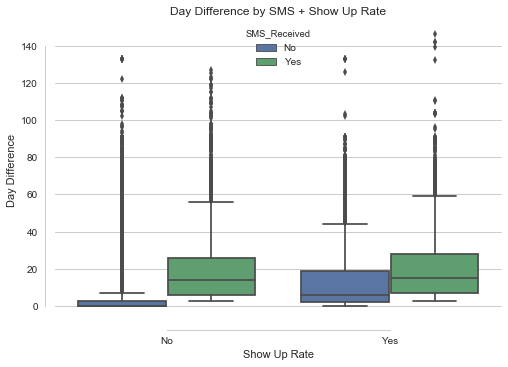

In [26]:
# Setting the overall aesthetic.
sns.set(style = 'whitegrid')

# Comparing groups using boxplots.
ax = sns.boxplot(x = 'No_Show', y = 'Day_Difference', hue = 'SMS_Received', data = temp_dat) 
                                #hue creates a subset with legend
sns.plt.title('Day Difference by SMS + Show Up Rate')
sns.despine(offset = 10, trim = True)
ax.set(xlabel = 'Show Up Rate', ylabel = 'Day Difference')

plt.savefig('day_diff_box.png')
plt.show()

* Majority of people receive SMS messages make appointment within 40 days of the appointment.
* Interestingly, individuals who makes appointment within a week are more likely to not show up.

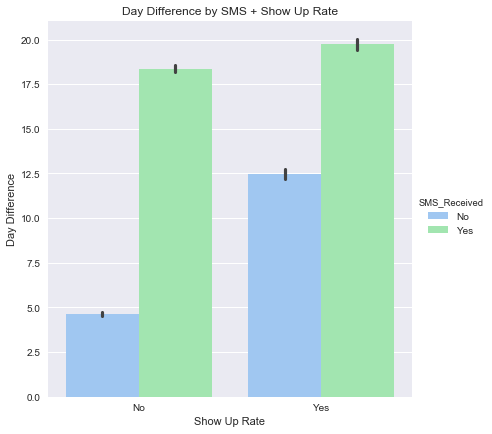

In [27]:
# Create a bar graph for day difference
# Setting the overall aesthetic
sns.set(style = 'darkgrid')

g = sns.factorplot(x = 'No_Show', y = 'Day_Difference', hue = 'SMS_Received', data = temp_dat,
                   size = 6, kind = "bar", palette = "pastel")
g.despine(left=True)
g.set_ylabels('Day Difference')
g.set_xlabels('Show Up Rate')
sns.plt.title('Day Difference by SMS + Show Up Rate')

plt.savefig('day_diff_bar.png')
plt.show()

Huge variance difference => high chi-square values

From this bar graph we found out that people who received messages tend to receive them weeks before the actual appointment day

In [28]:
# Analyze the no show rate based on day differences and sms received

# Categorize each group by day difference
diff_sms_no_show = sms[sms['No_Show'] == 'Yes'].groupby('Day_Difference').count()
dfff_no_sms_no_show = no_sms[no_sms['No_Show'] == 'Yes'].groupby('Day_Difference').count()

# create a dataframe
diff_sms_no_show =  pd.DataFrame(diff_sms_no_show)
dfff_no_sms_no_show =  pd.DataFrame(dfff_no_sms_no_show)

sms_temp = diff_sms_no_show['No_Show']
no_sms_temp = dfff_no_sms_no_show['No_Show']

print('T-test:', stats.ttest_ind(sms_temp, no_sms_temp))

T-test: Ttest_indResult(statistic=-0.98096420032412501, pvalue=0.32788462585327183)


do not reject the null hypothesis of average day difference being equal

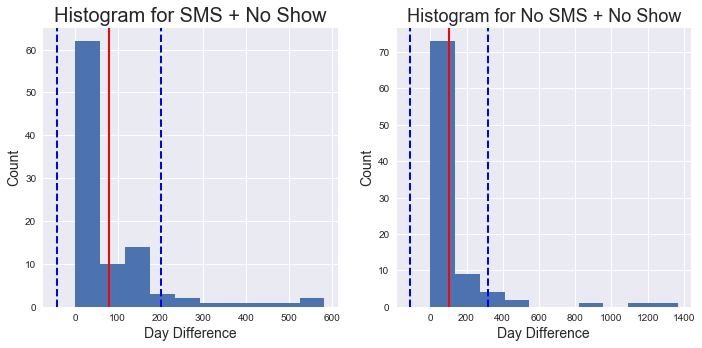

In [29]:
plt.figure(figsize = (10, 5))

# Plot histogram for SMS w/ No Show
plt.subplot(1, 2, 1)
plt.hist(sms_temp)

#Add a vertical line at mean and standard deviation
plt.axvline(sms_temp.mean(), color = 'red', linestyle = 'solid', linewidth = 2)
plt.axvline(sms_temp.mean() + sms_temp.std(), color = 'blue', linestyle = 'dashed', linewidth = 2)
plt.axvline(sms_temp.mean() - sms_temp.std(), color = 'blue', linestyle = 'dashed', linewidth = 2)
plt.title('Histogram for SMS + No Show', fontsize = 20)
plt.xlabel('Day Difference', fontsize = 14)
plt.ylabel('Count', fontsize = 14)

# Plot histogram for No SMS w/ No Show
plt.subplot(1, 2, 2)
plt.hist(no_sms_temp)

#Add a vertical line at mean and standard deviation
plt.axvline(no_sms_temp.mean(), color = 'red', linestyle = 'solid', linewidth = 2)
plt.axvline(no_sms_temp.mean() + no_sms_temp.std(), color = 'blue', linestyle = 'dashed', linewidth = 2)
plt.axvline(no_sms_temp.mean() - no_sms_temp.std(), color = 'blue', linestyle = 'dashed', linewidth = 2)
plt.title('Histogram for No SMS + No Show', fontsize = 18)
plt.xlabel('Day Difference', fontsize = 14)
plt.ylabel('Count', fontsize = 14)

plt.tight_layout()
plt.savefig('day_diff_histo.png')
plt.show()

# not normal distributed and big sample, still use ttest?

future notes: check for variance to decide which ttest to use